# This notebook is used to prepare and train the machine learning model used in the prediction website

In [1]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'
KAGGLE_FOLDER = DATA_FOLDER + 'kaggle/'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'
INFLATION_FILE = './gen/inflation_data.csv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'
KAGGLE_FILE = KAGGLE_FOLDER + 'movies_metadata.csv'

ethnicity_clusters = {1: 'White', 2: 'Black / African American', 3: 'Asian', 
    4: 'American Indian / Alaska Native', 5: 'Native Hawaiian / Other Pacific Islander',
    6: 'Other'}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime
import pickle

from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *
from ml_tools import *

# Neural Networks
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Normalization
from keras import Input

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

2022-12-23 19:32:03.422618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# load movies
movies = generate_clean_df(CHARACTERS_FILE, ETHNICITY_FILE, MOVIES_FILE, KAGGLE_FILE, INFLATION_FILE, ethnicity_clusters)
movies

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation,vote_average,vote_count,...,languages,countries,char_name,a_name,a_gender,a_ethnicity,a_is_hispanic,a_dob,a_age_at_release,a_height
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,4.8,299.0,...,[English Language],[United States of America],Akooshay,Wanda De Jesus,F,NaN,NaN,1958-08-26,42.0,1.620
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,4.8,299.0,...,[English Language],[United States of America],Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,NaN,1974-08-15,27.0,1.780
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,4.8,299.0,...,[English Language],[United States of America],Desolation Williams,Ice Cube,M,Black / African American,0.0,1969-06-15,32.0,1.727
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,4.8,299.0,...,[English Language],[United States of America],Sgt Jericho Butler,Jason Statham,M,NaN,NaN,1967-09-12,33.0,1.750
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,4.8,299.0,...,[English Language],[United States of America],Bashira Kincaid,Clea DuVall,F,NaN,NaN,1977-09-25,23.0,1.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450895,913762,NaN,NaN,1992-05-21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Elensh,Dorothy Elias-Fahn,F,NaN,NaN,1970-05,NaN,NaN
450896,913762,NaN,NaN,1992-05-21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Hibiki,Jonathan Fahn,M,NaN,NaN,1965-04-12,27.0,NaN
450897,28308153,NaN,NaN,1957-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,David Hemmings,M,White,0.0,1941-11-18,15.0,1.730
450898,28308153,NaN,NaN,1957-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Roberta Paterson,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# print unique NaN numbers for each column
movies.isna().sum()

wiki_movie_id                0
freebase_movie_id       206429
movie_name              206429
release_date             10010
box_office_revenue      354462
box_office_inflation    354462
budget                  387528
budget_inflation        387528
vote_average            306509
vote_count              306509
runtime                 220066
genres                  206429
languages               206429
countries               206429
char_name               257959
a_name                    1229
a_gender                 45624
a_ethnicity             347920
a_is_hispanic           347920
a_dob                   106181
a_age_at_release        158155
a_height                295938
dtype: int64

In [5]:
def drop_nulls(df):
    return df.dropna(subset=['release_date', 'box_office_revenue', 'budget', 'runtime', 'char_name', 'a_name', 'a_gender', 'a_ethnicity', 'a_dob', 'a_age_at_release', 'a_height'])

In [6]:
# Drop movies with NaN values
print(f'Movies: {movies.shape[0]}')
movies_dropna = drop_nulls(movies)
print(f'Movies With dropped nulls: {movies_dropna.shape[0]}')

Movies: 450900
Movies With dropped nulls: 14006


## With clean movies, we can add statistics about the ethnicities, genders, age and height

In [7]:
movies_stats = add_ethnicity_stats(movies_dropna, movies_dropna, ethnicity_clusters=ETHNICITY_CLUSTERS)
movies_stats = add_gender_stats(movies_stats, movies_stats)
movies_stats = add_age_height_weight_stats(movies_stats, movies_stats)
print("Movies with stats: ", movies_stats.shape[0])

Movies with stats:  14006


In [8]:
print(list(movies_stats.columns))
movies_stats.describe()

['wiki_movie_id', 'freebase_movie_id', 'movie_name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation', 'vote_average', 'vote_count', 'runtime', 'genres', 'languages', 'countries', 'char_name', 'a_name', 'a_gender', 'a_ethnicity', 'a_is_hispanic', 'a_dob', 'a_age_at_release', 'a_height', 'white_hispanic_ratio', 'white_not_hispanic_ratio', 'white_ratio', 'black_african_american_hispanic_ratio', 'black_african_american_not_hispanic_ratio', 'black_african_american_ratio', 'asian_hispanic_ratio', 'asian_not_hispanic_ratio', 'asian_ratio', 'american_indian_alaska_native_hispanic_ratio', 'american_indian_alaska_native_not_hispanic_ratio', 'american_indian_alaska_native_ratio', 'native_hawaiian_other_pacific_islander_hispanic_ratio', 'native_hawaiian_other_pacific_islander_not_hispanic_ratio', 'native_hawaiian_other_pacific_islander_ratio', 'other_hispanic_ratio', 'other_not_hispanic_ratio', 'other_ratio', 'nb_actors', 'nb_male', 'nb_female', 'nb_nan_g

,wiki_movie_id,box_office_revenue,box_office_inflation,budget,budget_inflation,vote_average,vote_count,runtime,a_is_hispanic,a_age_at_release,...,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio,a_age_at_release_mean,a_age_at_release_std,a_height_mean,a_height_std
count,1.400600e+04,1.400600e+04,1.400600e+04,1.400600e+04,1.400600e+04,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000,...,14006.000000,14006.0,14006.000000,14006.000000,14006.000000,14006.0,14006.000000,13497.000000,14006.000000,13497.000000
mean,6.596502e+06,1.377903e+08,2.361183e+08,4.664995e+07,7.709722e+07,6.254227,958.141511,112.655648,0.048408,38.463587,...,2.011923,0.0,0.672283,0.327717,2.187703,0.0,38.463587,11.659765,1.758381,0.093950
std,9.133973e+06,2.066055e+08,3.425709e+08,4.515126e+07,6.750217e+07,0.832772,1461.343161,28.115883,0.214634,13.771188,...,1.682703,0.0,0.231680,0.231680,1.959607,0.0,7.871612,5.349061,0.052211,0.041065
min,3.217000e+03,1.900000e+01,4.435000e+01,1.000000e+00,1.324869e+00,0.000000,0.000000,30.000000,0.000000,-11.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,8.000000,0.000000,1.067000,0.000000
25%,6.003510e+05,2.105075e+07,4.015380e+07,1.500000e+07,2.784929e+07,5.700000,150.000000,97.000000,0.000000,29.000000,...,1.000000,0.0,0.500000,0.166667,1.000000,0.0,33.600000,7.874008,1.727500,0.069926
50%,2.029825e+06,6.276100e+07,1.144788e+08,3.200000e+07,5.569859e+07,6.300000,429.000000,108.000000,0.000000,36.000000,...,2.000000,0.0,0.666667,0.333333,1.500000,0.0,38.444444,11.686174,1.760000,0.090526
75%,8.796061e+06,1.698528e+08,2.911609e+08,6.500000e+07,1.082607e+08,6.800000,1112.000000,123.000000,0.000000,47.000000,...,3.000000,0.0,0.833333,0.500000,3.000000,0.0,43.375000,15.238110,1.790100,0.113549
max,3.642336e+07,2.782275e+09,8.601212e+09,3.800000e+08,7.884444e+08,8.500000,14075.000000,1003.000000,1.000000,94.000000,...,10.000000,0.0,1.000000,1.000000,13.000000,0.0,84.000000,43.840620,1.963333,0.433456


## Get the top 100 actors by the total box office revenue of movies they appeared in

In [9]:
# top 100 actors sorted by box office revenue
top_actors = list(movies_stats.groupby('a_name')['box_office_revenue'].sum().sort_values(ascending=False).head(100).index)
top_actors[0:10]

['Samuel L. Jackson',
 'Tom Hanks',
 'Gary Oldman',
 'Eddie Murphy',
 'Alan Rickman',
 'Johnny Depp',
 'Robbie Coltrane',
 'Robert Downey Jr.',
 'Morgan Freeman',
 'Orlando Bloom']

In [10]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

## Extract the unique countries, languages and genres to prepare for one-hot encoding

In [11]:
countries = to_1D(movies_dropna['countries']).unique()
genres = to_1D(movies_dropna['genres']).unique()
languages = to_1D(movies_dropna['languages']).unique()

print(f'Countries: {len(countries)}')
print(f'Genres: {len(genres)}')
print(f'Languages: {len(languages)}')
print(f'Top Actors: {len(top_actors)}')

Countries: 56
Genres: 258
Languages: 102
Top Actors: 100


## Get the 30 most common genres

In [12]:
# count number of movies for each genre
top_genres = {}
for genre in genres:
    top_genres[genre] = movies_dropna[movies_dropna['genres'].apply(lambda x: genre in x)].shape[0]

top_genres = dict(sorted(top_genres.items(), key=lambda item: item[1], reverse=True))

# top 30 genres
top_genres = list(dict(list(top_genres.items())[0:30]).keys())
top_genres

['Drama',
 'Comedy',
 'Thriller',
 'Action',
 'Romance Film',
 'Action/Adventure',
 'Adventure',
 'Crime Fiction',
 'Fantasy',
 'Family Film',
 'Romantic comedy',
 'Science Fiction',
 'Period piece',
 'Mystery',
 'Film adaptation',
 'Crime Thriller',
 'Indie',
 'Horror',
 'Comedy-drama',
 'Romantic drama',
 'Animation',
 'Teen',
 'Psychological thriller',
 'War film',
 "Children's/Family",
 'Parody',
 'Black comedy',
 'Musical',
 'Coming of age',
 'Buddy film']

## Apply data augmentation (one-hot encoding, remove unwanted colums, etc...)

In [13]:
def augment_movies(movies, genres, actors, countries, languages, onehot=True):
    movies_augmented = movies.copy()

    if onehot:
        for genre in genres:
            movies_augmented[f'genre:{genre}'] = movies_augmented['genres'].apply(lambda x: 1 if genre in x else 0)


        for actor in actors:
            movies_augmented[f'actor:{actor}'] = movies_augmented['a_name'].apply(lambda x: 1 if actor in x else 0)

        #for country in countries:
        #    movies_augmented[f'country:{country}'] = movies_augmented['countries'].apply(lambda x: 1 if country in x else 0)

        # for language in languages:
        #     movies_augmented[f'language:{language}'] = movies_augmented['languages'].apply(lambda x: 1 if language in x else 0)

    movies_augmented['release_date'] = movies_augmented['release_date'].dt.year
    movies_augmented['runtime'] = movies_augmented['runtime'].apply(lambda x: x if not pd.isna(x) else 0)


    film_info = ['wiki_movie_id', 'freebase_movie_id', 'movie_name', 'budget', 'box_office_revenue', 'languages', 'countries', 'genres', 'vote_average', 'vote_count']
    actor_info = ['char_name', 'a_dob', 'a_gender', 'a_height', 'a_name', 'a_age_at_release', 'a_is_hispanic', 'a_ethnicity']
    stasts_info = ['nb_actors', 'nb_male', 'nb_female', 'nb_nan_gender', 'nan_ratio', 'M_F_ratio']
    hispanic_info = ['white_hispanic_ratio', 'white_not_hispanic_ratio', 'black_african_american_hispanic_ratio', 'black_african_american_not_hispanic_ratio', 'asian_hispanic_ratio', 'asian_not_hispanic_ratio', 'american_indian_alaska_native_hispanic_ratio', 'american_indian_alaska_native_not_hispanic_ratio', 'native_hawaiian_other_pacific_islander_hispanic_ratio', 'native_hawaiian_other_pacific_islander_not_hispanic_ratio', 'other_hispanic_ratio', 'other_not_hispanic_ratio']

    to_drop = film_info + actor_info + stasts_info + hispanic_info
               
    movies_augmented = movies_augmented.drop(to_drop, axis=1)

    print(f"Actor/movies: {movies_augmented.shape[0]}")
    # remove duplicates
    movies_augmented = movies_augmented.drop_duplicates()
    print(f"Individual movies: {movies_augmented.shape[0]}")

    
    print(f"NaNs remaining (set to 0): {movies_augmented.isna().sum().sum()}")
    movies_augmented = movies_augmented.fillna(0)

    return movies_augmented

dataset1 = augment_movies(movies_stats, genres=top_genres, actors=top_actors, countries=countries, languages=languages, onehot=True)

print(list(dataset1.columns))
dataset1

Actor/movies: 14006
Individual movies: 5146
NaNs remaining (set to 0): 1018
['release_date', 'box_office_inflation', 'budget_inflation', 'runtime', 'white_ratio', 'black_african_american_ratio', 'asian_ratio', 'american_indian_alaska_native_ratio', 'native_hawaiian_other_pacific_islander_ratio', 'other_ratio', 'm_ratio', 'f_ratio', 'a_age_at_release_mean', 'a_age_at_release_std', 'a_height_mean', 'a_height_std', 'genre:Drama', 'genre:Comedy', 'genre:Thriller', 'genre:Action', 'genre:Romance Film', 'genre:Action/Adventure', 'genre:Adventure', 'genre:Crime Fiction', 'genre:Fantasy', 'genre:Family Film', 'genre:Romantic comedy', 'genre:Science Fiction', 'genre:Period piece', 'genre:Mystery', 'genre:Film adaptation', 'genre:Crime Thriller', 'genre:Indie', 'genre:Horror', 'genre:Comedy-drama', 'genre:Romantic drama', 'genre:Animation', 'genre:Teen', 'genre:Psychological thriller', 'genre:War film', "genre:Children's/Family", 'genre:Parody', 'genre:Black comedy', 'genre:Musical', 'genre:Comi

,release_date,box_office_inflation,budget_inflation,runtime,white_ratio,black_african_american_ratio,asian_ratio,american_indian_alaska_native_ratio,native_hawaiian_other_pacific_islander_ratio,other_ratio,...,actor:David Thewlis,actor:Hugh Jackman,actor:Wes Studi,actor:Anthony Hopkins,actor:Kirsten Dunst,actor:Pierce Brosnan,actor:Lawrence Makoare,actor:Keanu Reeves,actor:Danny DeVito,actor:Stan Lee
0,2001,2.358180e+07,4.712713e+07,98.0,0.000000,1.000000,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2001,4.945260e+07,2.692979e+07,123.0,0.000000,1.000000,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2001,4.945260e+07,2.692979e+07,123.0,0.000000,1.000000,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,1971,8.206648e+07,1.619419e+07,118.0,1.000000,0.000000,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
10,1971,8.206648e+07,1.619419e+07,118.0,1.000000,0.000000,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13992,1995,1.625123e+08,2.151488e+07,122.0,1.000000,0.000000,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
13994,1997,2.142211e+07,1.021141e+08,101.0,0.857143,0.142857,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
13996,1997,2.142211e+07,1.021141e+08,101.0,0.857143,0.142857,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
14001,2000,2.008113e+06,3.461463e+05,93.0,1.000000,0.000000,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Plot the main numerical values in the dataset

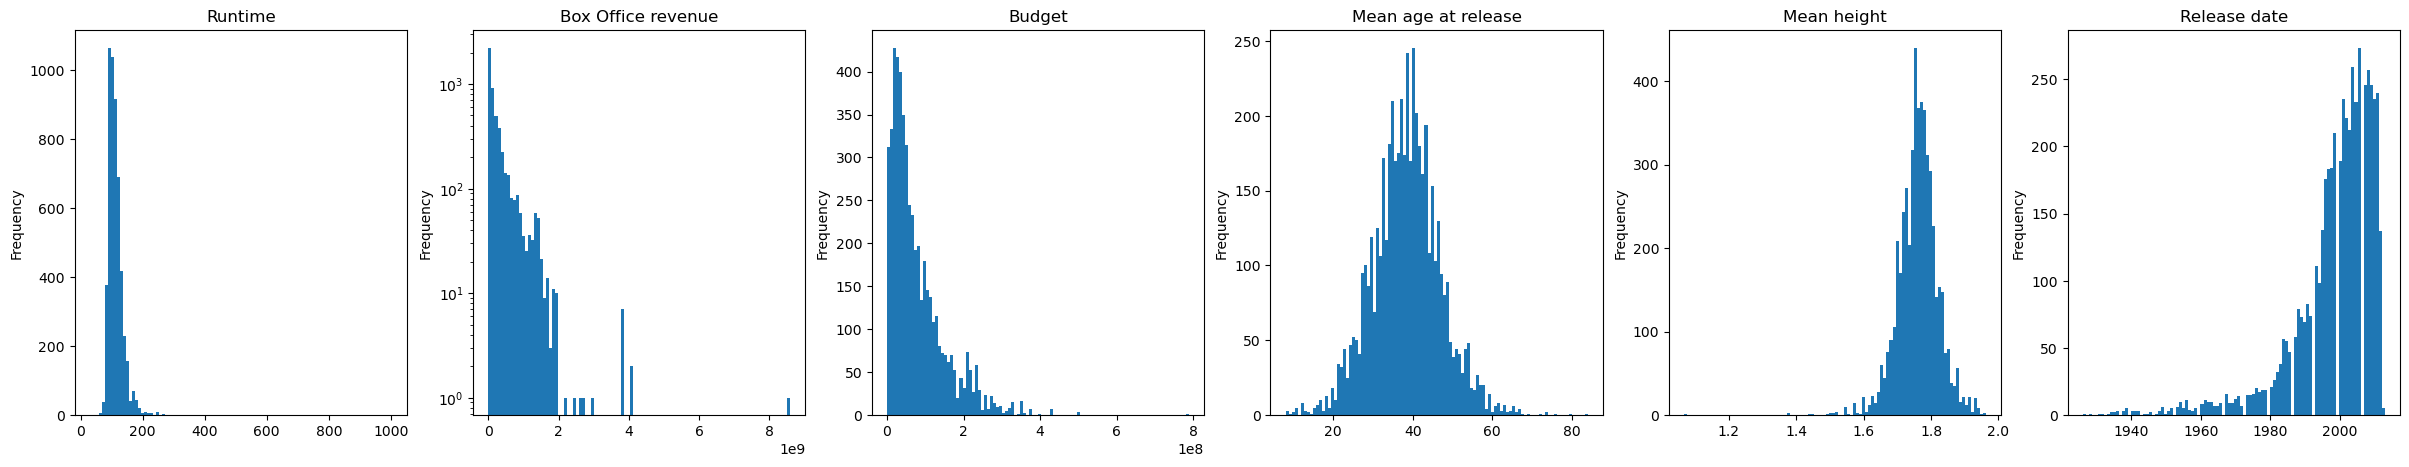

In [14]:
def plot_dataset(dataset):
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))

    dataset["runtime"].plot.hist(bins=100, ax=axs[0])
    dataset["box_office_inflation"].plot.hist(bins=100, log=True, ax=axs[1])
    dataset["budget_inflation"].plot.hist(bins=100, ax=axs[2])
    dataset["a_age_at_release_mean"].plot.hist(bins=100, ax=axs[3])
    dataset["a_height_mean"].plot.hist(bins=100, ax=axs[4])
    dataset["release_date"].plot.hist(bins=100, ax=axs[5])

    axs[0].set_title("Runtime")
    axs[1].set_title("Box Office revenue")
    axs[2].set_title("Budget")
    axs[3].set_title("Mean age at release")
    axs[4].set_title("Mean height")
    axs[5].set_title("Release date")
    plt.show()

plot_dataset(dataset1)

In [15]:
def remove_outliers(dataset, column, q_low, q_high):
    new_dataset = dataset[(dataset[column] > dataset[column].quantile(q_low)) & (dataset[column] < dataset[column].quantile(q_high))]
    print(f'Dropped {dataset.shape[0] - new_dataset.shape[0]} outliers from {column}')
    return new_dataset

# Remove 0 to 1% of outliers on each side for the main numerical features

Dropped 109 outliers from runtime
Dropped 55 outliers from box_office_inflation
Dropped 55 outliers from budget_inflation
Dropped 126 outliers from release_date


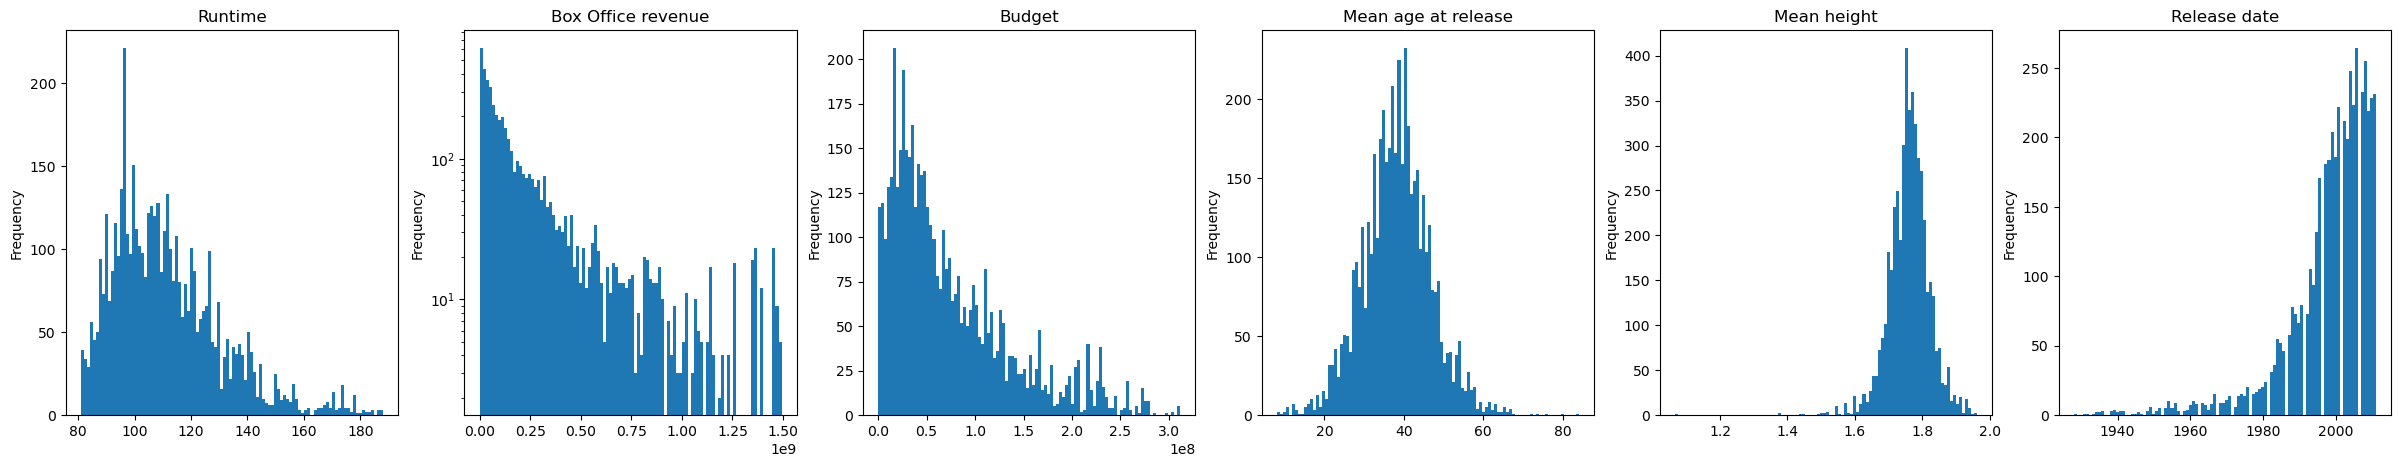

In [16]:
dataset2 = dataset1.copy()

dataset2 = remove_outliers(dataset2, 'runtime', 0.01, 0.99)
dataset2 = remove_outliers(dataset2, 'box_office_inflation', 0, 0.99)
dataset2 = remove_outliers(dataset2, 'budget_inflation', 0, 0.99)
dataset2 = remove_outliers(dataset2, 'release_date', 0, 0.99)
plot_dataset(dataset2)

## Standardize the dataframe to have numerically close values, and save the relevant values to reverse this process

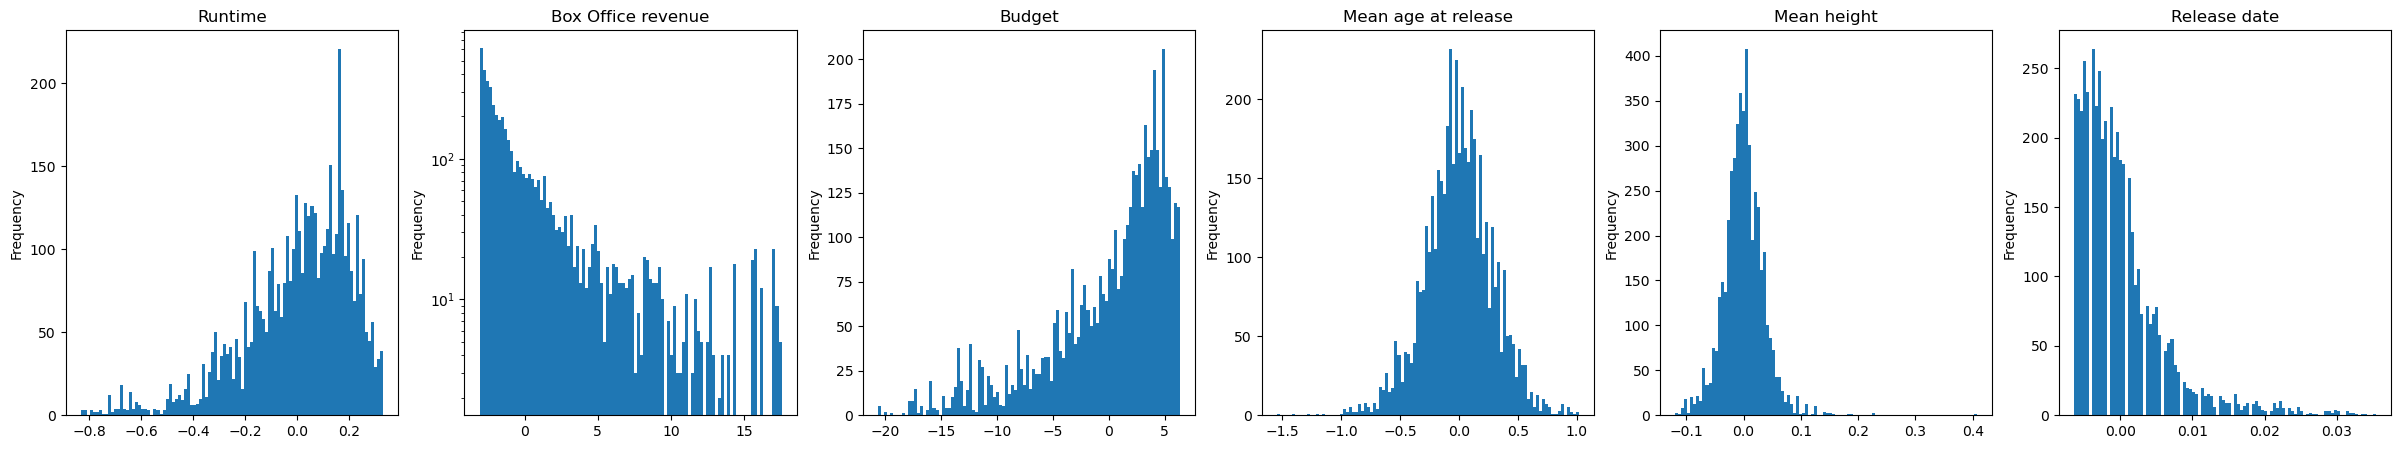

In [17]:
dataset3 = dataset2.copy()

# Standardize the data for certain columns
#columns = ['runtime', 'budget_inflation', 'box_office_inflation', 'a_age_at_release_mean', 'a_height_mean', 'a_age_at_release_std', 'a_height_std', 'release_date']
columns = list(dataset3.columns)
means = {}
stds = {}
mins = {}
maxs = {}

for column in columns:
    means[column] = dataset3[column].mean()
    stds[column] = dataset3[column].std()
    mins[column] = dataset3[column].min()
    maxs[column] = dataset3[column].max()

dataset3 = normalize(dataset3, columns, means, stds)

plot_dataset(dataset3)

## Split the clean dataset into train and test datasets

In [18]:
dataset = dataset3.copy()

x, y = dataset.drop(['box_office_inflation'], axis=1), dataset['box_office_inflation']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
def plot_loss(history, ax, log=False):
    """
    Plot the loss of the model

    Parameters
    ----------
    history : dict
        The history of the model
    ax : matplotlib.axes._subplots.AxesSubplot
        The subplot to plot on
    log : bool  
        Whether to plot the loss on a log scale
    """
    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    if log:
        ax.set_yscale('log')

    ax.set_title('Model loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['train', 'test'], loc='upper right')

def plot_preds_heatmap(y_pred, y_test, ax, displot):
    """
    Plot the predicted vs actual values

    Parameters
    ----------
    y_pred : numpy.ndarray
        The predicted values
    y_test : numpy.ndarray
        The actual values
    ax : matplotlib.axes._subplots.AxesSubplot
        The subplot to plot on
    displot : bool
        Whether to plot a displot
    """
    if displot:
        sns.displot(x=y_pred, y=y_test, kind="kde", fill=True, thresh=0.05, levels=10, ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.scatter(x=y_pred, y=y_test, alpha=0.3, s=5, c='red')

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Predicted vs Actual')

In [20]:
def baseline_model(input_dim, lr):
    """
    Create a baseline deep neural network model

    Parameters
    ----------
    input_dim : int
        The number of input features
    lr : float
        The learning rate
    """
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))

    return model

## Create the model, and train in

In [21]:
model = baseline_model(x_train.shape[1], lr=1e-4)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=200,
                    batch_size=128,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

2022-12-23 19:32:47.229787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 19:32:47.231364: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

## After training, plot the results

In [24]:
def plot_model(history, model, x_test, y_test, displot=False, log=False):    
    y_pred = model.predict(x_test)
    pred = y_pred[:, 0]
    test = y_test.to_numpy()
    df = pd.DataFrame({'pred': pred, 'test': test})

    df = denormalize_column(df, 'pred', means['box_office_inflation'], stds['box_office_inflation'])
    df = denormalize_column(df, 'test', means['box_office_inflation'], stds['box_office_inflation'])

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_loss(history.history, ax[0], log=log)
    plot_preds_heatmap(df["pred"], df["test"], ax[1], displot)

31/31 [==============================] - 0s 6ms/step


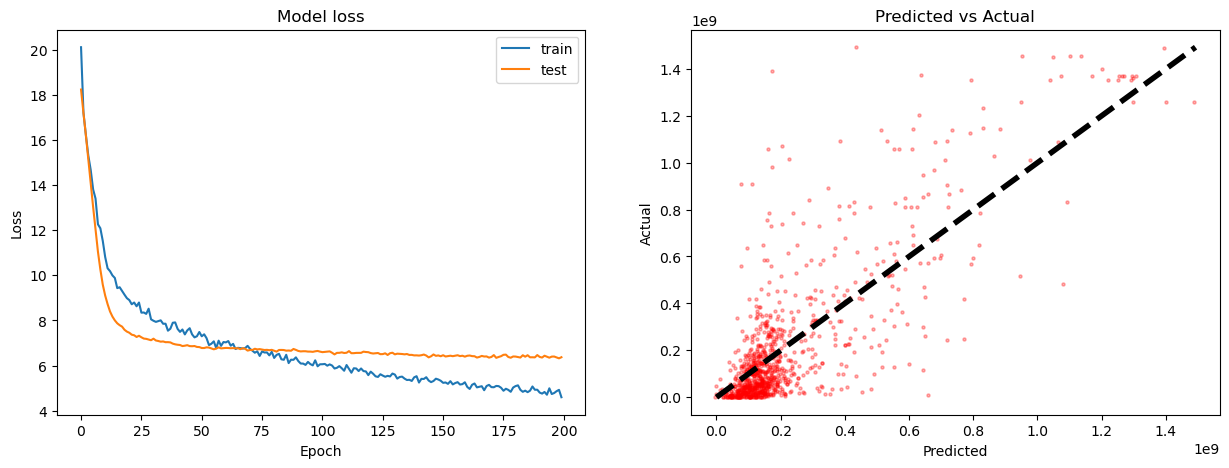

In [25]:
plot_model(history, model, x_test, y_test, displot=False, log=False)

## Finally, save the models and important data for the prediction website

In [26]:
# save model and important objects
model.save('model/model.h5')

with open('model/means.pkl', 'wb') as f:
    pickle.dump(means, f)
with open('model/stds.pkl', 'wb') as f:
    pickle.dump(stds, f)
with open('model/mins.pkl', 'wb') as f:
    pickle.dump(mins, f)
with open('model/maxs.pkl', 'wb') as f:
    pickle.dump(maxs, f)
with open('model/actors.pkl', 'wb') as f:
    pickle.dump(top_actors, f)
with open('model/genres.pkl', 'wb') as f:
    pickle.dump(top_genres, f)
with open('model/columns.pkl', 'wb') as f:
    pickle.dump(columns, f)